In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from glm_granger import compute_granger_causality, permutation_test, filter_indirect_connections
from joblib import Parallel, delayed
from scipy.stats import spearmanr

from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

Data contains 3 neurons, 100 trials, and 100 time steps.


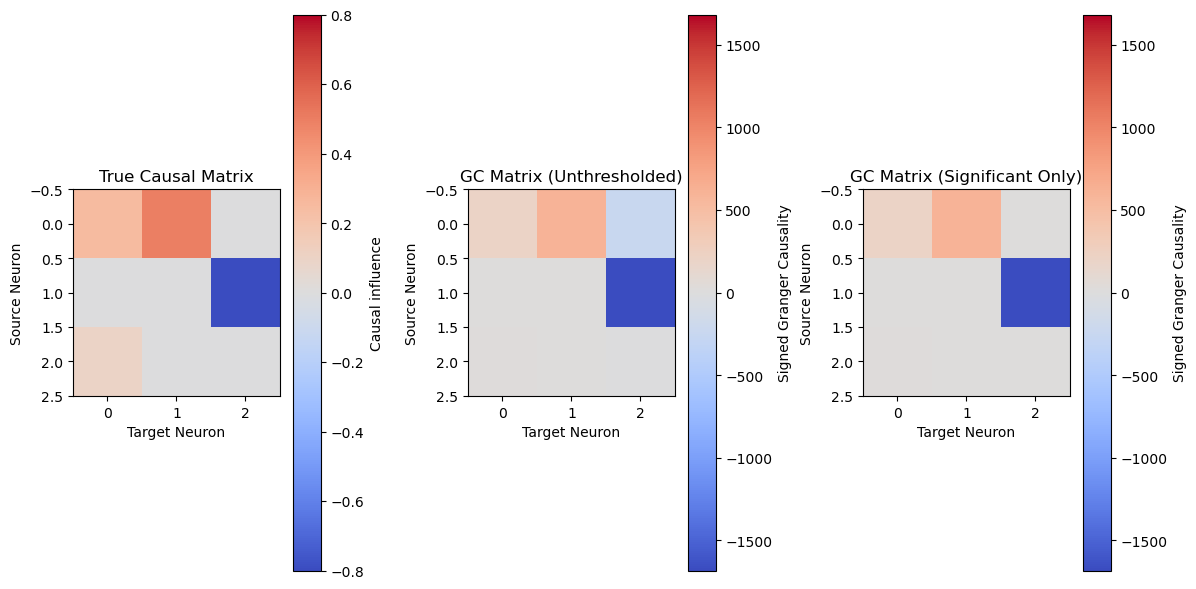

Granger Causality Matrix (Unthresholded):
[[1.98225363e+02 5.99528592e+02 2.37973280e+02]
 [1.86323472e+00 4.12529297e-01 1.68434553e+03]
 [1.77635047e+01 3.44624186e+00 2.25241408e-01]]
signed Granger Causality Matrix (Unthresholded):
[[ 1.98225363e+02  5.99528592e+02 -2.37973280e+02]
 [ 1.86323472e+00  4.12529297e-01 -1.68434553e+03]
 [ 1.77635047e+01  3.44624186e+00 -2.25241408e-01]]

Significant Granger Causality Matrix:
[[  198.22536335   599.52859214     0.        ]
 [    0.             0.         -1684.34552795]
 [   17.76350471     0.             0.        ]]
Spearman rho=1.0, p=0.0


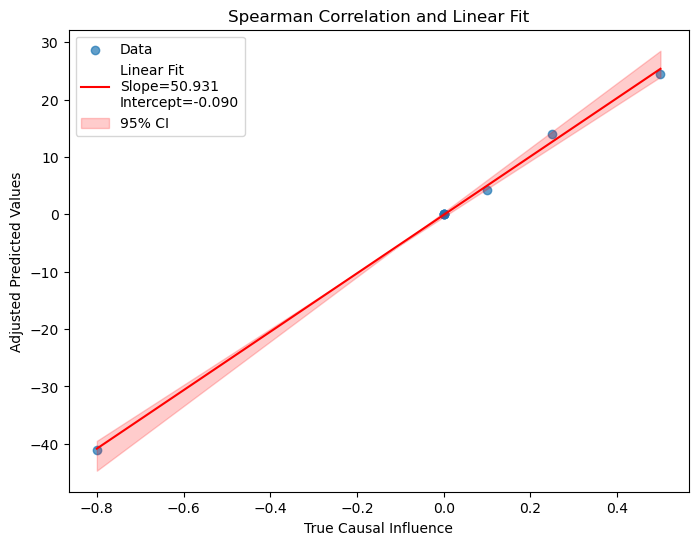

In [3]:
# Function to generate synthetic spike train data for trials
def generate_synthetic_spike_data_trials(neurons, trials, time_steps, causal_matrix, base_rate=0.01, noise_level=0.1):
    data = np.zeros((neurons, trials, time_steps))
    for trial in range(trials):
        for t in range(1, time_steps):
            for i in range(neurons):
                firing_rate = base_rate
                for j in range(neurons):
                    if causal_matrix[j, i] != 0:
                        firing_rate += causal_matrix[j, i] * data[j, trial, t - 1]
                firing_prob = max(0, min(1, firing_rate + np.random.normal(0, noise_level)))
                data[i, trial, t] = 1 if np.random.rand() < firing_prob else 0
    return data

# Simulate synthetic spike train data for trials
causal_matrix = np.array([
    [0.25, 0.5, 0.0],
    [0.0, 0.0, -0.8],
    [0.1, 0.0, 0.0]
])
simulated_data_trials = generate_synthetic_spike_data_trials(
    neurons=3, trials=100, time_steps=100, causal_matrix=causal_matrix, base_rate=0.3, noise_level=0.3
)

# Analyze Granger causality with cross-validation
optimal_lags, gc_matrix, signed_gc_matrix = compute_granger_causality(
    simulated_data_trials, 
    lags=np.arange(1, 20)
)

# Filter indirect connections
filtered_gc_matrix, filtered_signed_gc_matrix = filter_indirect_connections(
    optimal_lags,
    gc_matrix,
    signed_gc_matrix
)

# Perform permutation test
significant_gc_matrix, null_distribution, permuted_gc_matrices = permutation_test(
    optimal_lags,
    filtered_gc_matrix,
    filtered_signed_gc_matrix,
    simulated_data_trials,
    n_permutations=1000,
    n_jobs=4
)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
maxabs = np.max(np.abs(causal_matrix))
plt.imshow(causal_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Causal influence')
plt.title("True Causal Matrix")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 2)
maxabs = np.max(np.abs(signed_gc_matrix))
plt.imshow(signed_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Unthresholded)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 3)
maxabs = np.max(np.abs(significant_gc_matrix))
plt.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Significant Only)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.tight_layout()
plt.show()

# Print Granger causality matrix
print("Granger Causality Matrix (Unthresholded):")
print(gc_matrix)
print("signed Granger Causality Matrix (Unthresholded):")
print(signed_gc_matrix)
print("\nSignificant Granger Causality Matrix:")
print(significant_gc_matrix)


# Flatten the matrices
true_values = causal_matrix.flatten()
predicted_values = significant_gc_matrix.flatten()

adjusted_predicted_values=np.sign(predicted_values)*np.sqrt(np.abs(predicted_values))

# Compute Spearman correlation
spearman_corr, spearman_pval = spearmanr(true_values, adjusted_predicted_values)

# Bootstrapped confidence intervals for linear regression
bootstrapped_slopes = []
bootstrapped_intercepts = []
n_bootstraps = 1000
for _ in range(n_bootstraps):
    resampled_true, resampled_predicted = resample(true_values, adjusted_predicted_values)
    if not np.all(resampled_true==0):
        slope, intercept = np.polyfit(resampled_true, resampled_predicted, 1)
        bootstrapped_slopes.append(slope)
        bootstrapped_intercepts.append(intercept)

# Compute 95% CI
slope_ci = np.percentile(bootstrapped_slopes, [2.5, 97.5])
intercept_ci = np.percentile(bootstrapped_intercepts, [2.5, 97.5])

# Fit the linear regression line for plotting
slope, intercept = np.polyfit(true_values, adjusted_predicted_values, 1)
line_x = np.linspace(true_values.min(), true_values.max(), 100)
line_y = slope * line_x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_values, adjusted_predicted_values, alpha=0.7, label='Data')
plt.plot(line_x, line_y, color='red', label=f'Linear Fit\nSlope={slope:.3f}\nIntercept={intercept:.3f}')
plt.fill_between(line_x, slope_ci[0] * line_x + intercept_ci[0], slope_ci[1] * line_x + intercept_ci[1], 
                 color='red', alpha=0.2, label='95% CI')
plt.xlabel('True Causal Influence')
plt.ylabel('Adjusted Predicted Values')
plt.title('Spearman Correlation and Linear Fit')
plt.legend()

# Display Spearman results
print(f'Spearman rho={spearman_corr}, p={spearman_pval}')


Data contains 3 neurons, 100 trials, and 100 time steps.


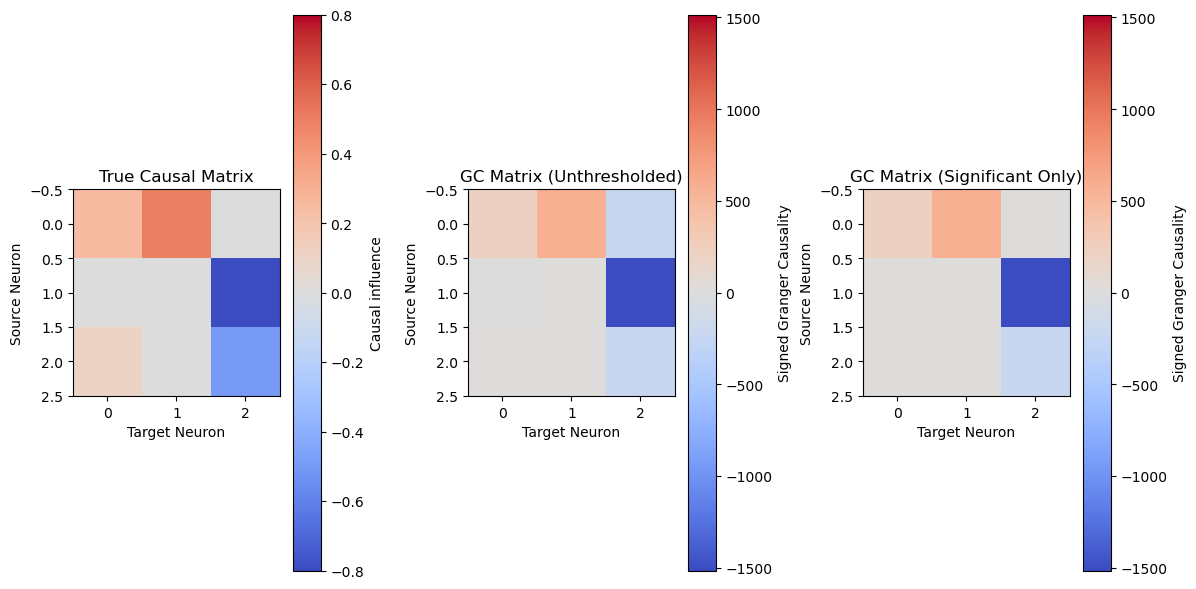

Granger Causality Matrix (Unthresholded):
[[2.10031569e+02 5.68718220e+02 2.38706631e+02]
 [7.30521837e-01 2.49134192e-01 1.51632102e+03]
 [1.31310166e+01 7.56951666e-01 2.21421475e+02]]
signed Granger Causality Matrix (Unthresholded):
[[ 2.10031569e+02  5.68718220e+02 -2.38706631e+02]
 [-7.30521837e-01  2.49134192e-01 -1.51632102e+03]
 [ 1.31310166e+01  7.56951666e-01 -2.21421475e+02]]

Significant Granger Causality Matrix:
[[  210.03156857   568.71821972     0.        ]
 [    0.             0.         -1516.32102453]
 [   13.13101663     0.          -221.42147488]]
Spearman rho=1.0, p=0.0


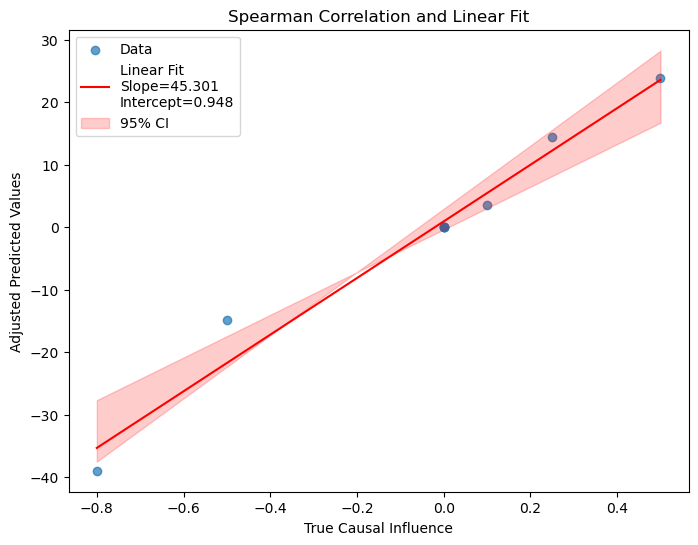

In [4]:
# Simulate synthetic spike train data for trials
causal_matrix = np.array([
    [0.25, 0.5, 0.0],
    [0.0, 0.0, -0.8],
    [0.1, 0.0, -0.5]
])
simulated_data_trials = generate_synthetic_spike_data_trials(
    neurons=3, trials=100, time_steps=100, causal_matrix=causal_matrix, base_rate=0.3, noise_level=0.3
)

# Analyze Granger causality with cross-validation
optimal_lags, gc_matrix, signed_gc_matrix = compute_granger_causality(
    simulated_data_trials, 
    lags=np.arange(1, 20)
)

# Filter indirect connections
filtered_gc_matrix, filtered_signed_gc_matrix = filter_indirect_connections(
    optimal_lags,
    gc_matrix,
    signed_gc_matrix
)

# Perform permutation test
significant_gc_matrix, null_distribution, permuted_gc_matrices = permutation_test(
    optimal_lags,
    filtered_gc_matrix,
    filtered_signed_gc_matrix,
    simulated_data_trials,
    n_permutations=1000,
    n_jobs=4
)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
maxabs = np.max(np.abs(causal_matrix))
plt.imshow(causal_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Causal influence')
plt.title("True Causal Matrix")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 2)
maxabs = np.max(np.abs(signed_gc_matrix))
plt.imshow(signed_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Unthresholded)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 3)
maxabs = np.max(np.abs(significant_gc_matrix))
plt.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Significant Only)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.tight_layout()
plt.show()

# Print Granger causality matrix
print("Granger Causality Matrix (Unthresholded):")
print(gc_matrix)
print("signed Granger Causality Matrix (Unthresholded):")
print(signed_gc_matrix)
print("\nSignificant Granger Causality Matrix:")
print(significant_gc_matrix)


# Flatten the matrices
true_values = causal_matrix.flatten()
predicted_values = significant_gc_matrix.flatten()

adjusted_predicted_values=np.sign(predicted_values)*np.sqrt(np.abs(predicted_values))

# Compute Spearman correlation
spearman_corr, spearman_pval = spearmanr(true_values, adjusted_predicted_values)

# Bootstrapped confidence intervals for linear regression
bootstrapped_slopes = []
bootstrapped_intercepts = []
n_bootstraps = 1000
for _ in range(n_bootstraps):
    resampled_true, resampled_predicted = resample(true_values, adjusted_predicted_values)
    if not np.all(resampled_true==0):
        slope, intercept = np.polyfit(resampled_true, resampled_predicted, 1)
        bootstrapped_slopes.append(slope)
        bootstrapped_intercepts.append(intercept)

# Compute 95% CI
slope_ci = np.percentile(bootstrapped_slopes, [2.5, 97.5])
intercept_ci = np.percentile(bootstrapped_intercepts, [2.5, 97.5])

# Fit the linear regression line for plotting
slope, intercept = np.polyfit(true_values, adjusted_predicted_values, 1)
line_x = np.linspace(true_values.min(), true_values.max(), 100)
line_y = slope * line_x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_values, adjusted_predicted_values, alpha=0.7, label='Data')
plt.plot(line_x, line_y, color='red', label=f'Linear Fit\nSlope={slope:.3f}\nIntercept={intercept:.3f}')
plt.fill_between(line_x, slope_ci[0] * line_x + intercept_ci[0], slope_ci[1] * line_x + intercept_ci[1], 
                 color='red', alpha=0.2, label='95% CI')
plt.xlabel('True Causal Influence')
plt.ylabel('Adjusted Predicted Values')
plt.title('Spearman Correlation and Linear Fit')
plt.legend()

# Display Spearman results
print(f'Spearman rho={spearman_corr}, p={spearman_pval}')


Data contains 4 neurons, 100 trials, and 100 time steps.


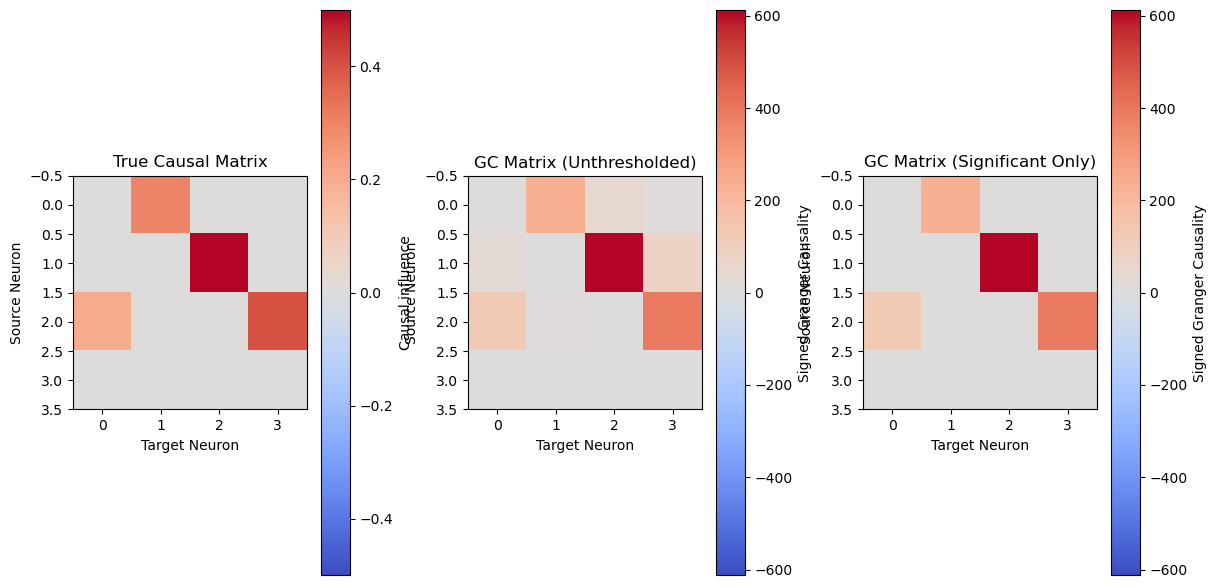

Granger Causality Matrix (Unthresholded):
[[2.37803566e-01 2.30522588e+02 4.43538860e+01 5.13543739e+00]
 [2.69966907e+01 3.04909929e-01 6.12362288e+02 8.03736414e+01]
 [1.23857200e+02 9.29686208e+00 1.32272131e+00 3.89799334e+02]
 [4.24143964e-04 2.69786817e-02 5.00228298e-01 2.38109872e+00]]
signed Granger Causality Matrix (Unthresholded):
[[ 2.37803566e-01  2.30522588e+02  4.43538860e+01  5.13543739e+00]
 [ 2.69966907e+01 -3.04909929e-01  6.12362288e+02  8.03736414e+01]
 [ 1.23857200e+02  9.29686208e+00  1.32272131e+00  3.89799334e+02]
 [-4.24143964e-04  2.69786817e-02 -5.00228298e-01  2.38109872e+00]]

Significant Granger Causality Matrix:
[[  0.         230.52258834   0.           0.        ]
 [  0.           0.         612.36228766   0.        ]
 [123.8571999    0.           0.         389.79933432]
 [  0.           0.           0.           2.38109872]]
Spearman rho=0.9254845969168989, p=2.80422723867888e-07


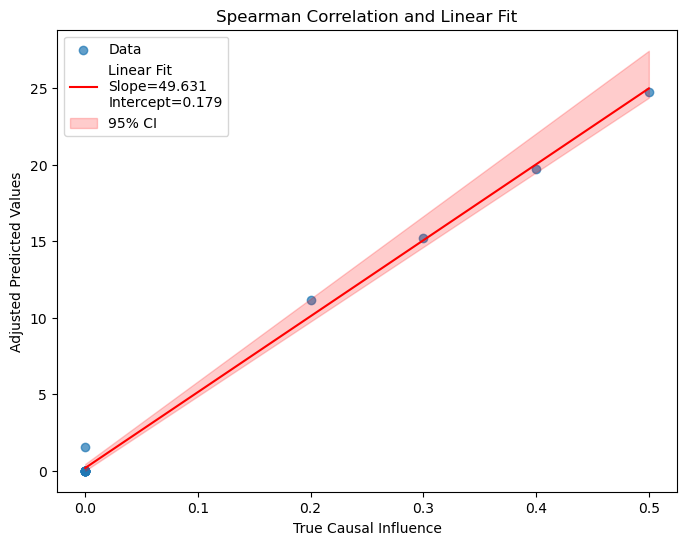

In [5]:
# Simulate synthetic spike train data for trials
causal_matrix = np.array([
    [0.0,  0.3, 0.0, 0.0],  # Neuron 0 causes Neuron 1
    [0.0,  0.0, 0.5, 0.0],  # Neuron 1 causes Neuron 2
    [0.2,  0.0, 0.0, 0.4],  # Neuron 2 causes Neurons 0 and 3
    [0.0,  0.0, 0.0, 0.0],  # Neuron 3 has no outgoing connections
])
simulated_data_trials = generate_synthetic_spike_data_trials(
    neurons=4, trials=100, time_steps=100, causal_matrix=causal_matrix, base_rate=0.3, noise_level=0.3
)

# Analyze Granger causality with cross-validation
optimal_lags, gc_matrix, signed_gc_matrix = compute_granger_causality(
    simulated_data_trials, 
    lags=np.arange(1, 20)
)

# Filter indirect connections
filtered_gc_matrix, filtered_signed_gc_matrix = filter_indirect_connections(
    optimal_lags,
    gc_matrix,
    signed_gc_matrix
)

# Perform permutation test
significant_gc_matrix, null_distribution, permuted_gc_matrices = permutation_test(
    optimal_lags,
    filtered_gc_matrix,
    filtered_signed_gc_matrix,
    simulated_data_trials,
    n_permutations=1000,
    n_jobs=4
)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
maxabs = np.max(np.abs(causal_matrix))
plt.imshow(causal_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Causal influence')
plt.title("True Causal Matrix")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 2)
maxabs = np.max(np.abs(signed_gc_matrix))
plt.imshow(signed_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Unthresholded)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 3)
maxabs = np.max(np.abs(significant_gc_matrix))
plt.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Significant Only)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.tight_layout()
plt.show()

# Print Granger causality matrix
print("Granger Causality Matrix (Unthresholded):")
print(gc_matrix)
print("signed Granger Causality Matrix (Unthresholded):")
print(signed_gc_matrix)
print("\nSignificant Granger Causality Matrix:")
print(significant_gc_matrix)


# Flatten the matrices
true_values = causal_matrix.flatten()
predicted_values = significant_gc_matrix.flatten()

adjusted_predicted_values=np.sign(predicted_values)*np.sqrt(np.abs(predicted_values))

# Compute Spearman correlation
spearman_corr, spearman_pval = spearmanr(true_values, adjusted_predicted_values)

# Bootstrapped confidence intervals for linear regression
bootstrapped_slopes = []
bootstrapped_intercepts = []
n_bootstraps = 1000
for _ in range(n_bootstraps):
    resampled_true, resampled_predicted = resample(true_values, adjusted_predicted_values)
    if not np.all(resampled_true==0):
        slope, intercept = np.polyfit(resampled_true, resampled_predicted, 1)
        bootstrapped_slopes.append(slope)
        bootstrapped_intercepts.append(intercept)

# Compute 95% CI
slope_ci = np.percentile(bootstrapped_slopes, [2.5, 97.5])
intercept_ci = np.percentile(bootstrapped_intercepts, [2.5, 97.5])

# Fit the linear regression line for plotting
slope, intercept = np.polyfit(true_values, adjusted_predicted_values, 1)
line_x = np.linspace(true_values.min(), true_values.max(), 100)
line_y = slope * line_x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_values, adjusted_predicted_values, alpha=0.7, label='Data')
plt.plot(line_x, line_y, color='red', label=f'Linear Fit\nSlope={slope:.3f}\nIntercept={intercept:.3f}')
plt.fill_between(line_x, slope_ci[0] * line_x + intercept_ci[0], slope_ci[1] * line_x + intercept_ci[1], 
                 color='red', alpha=0.2, label='95% CI')
plt.xlabel('True Causal Influence')
plt.ylabel('Adjusted Predicted Values')
plt.title('Spearman Correlation and Linear Fit')
plt.legend()

# Display Spearman results
print(f'Spearman rho={spearman_corr}, p={spearman_pval}')


Data contains 6 neurons, 100 trials, and 100 time steps.


/home/bonaiuto/miniconda3/envs/poisson_glm_granger/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


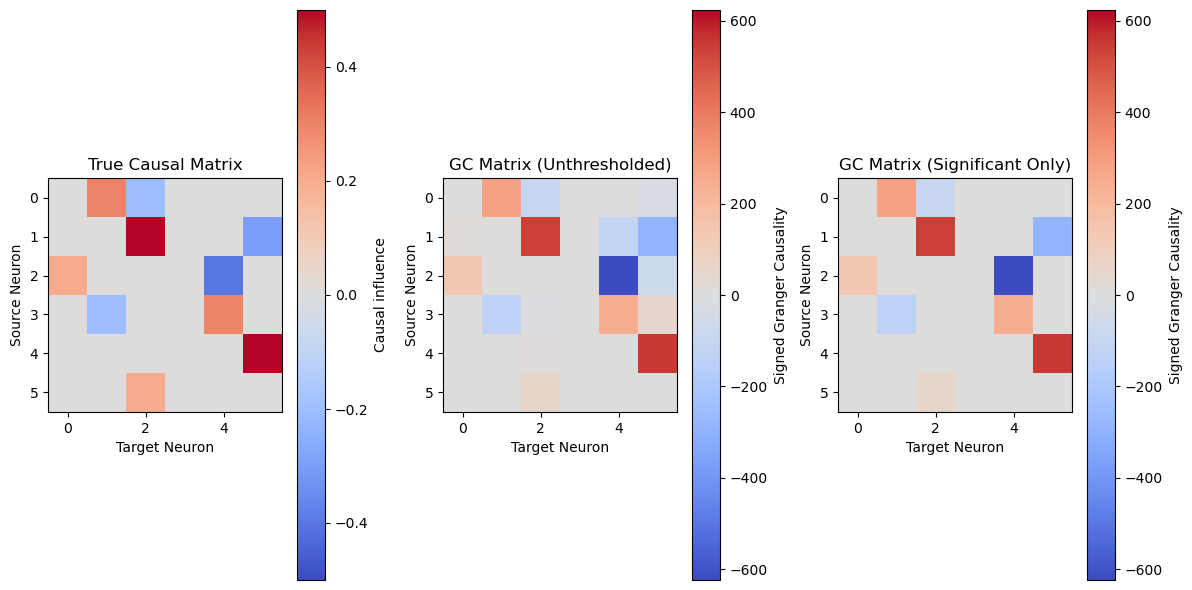

Granger Causality Matrix (Unthresholded):
[[7.39357457e-01 2.86477520e+02 9.71355291e+01 9.19526304e-02
  3.00098440e+00 2.06966147e+01]
 [1.72700997e+01 8.55361484e-02 5.40098623e+02 1.55680594e-01
  1.09979580e+02 2.85919477e+02]
 [1.37649260e+02 2.92954659e-01 3.85666213e-01 3.60962339e-02
  6.23418737e+02 7.02820889e+01]
 [1.78842588e-01 1.33079090e+02 1.26798030e+01 1.21334428e-01
  2.48067847e+02 5.10234472e+01]
 [1.80760558e+00 1.63572376e-01 6.89777964e+00 7.47011450e-01
  3.99999124e-01 5.52215063e+02]
 [1.72146372e-02 2.84891596e-01 5.96590474e+01 2.25375878e-01
  7.04837908e-01 2.27393926e-01]]
signed Granger Causality Matrix (Unthresholded):
[[-7.39357457e-01  2.86477520e+02 -9.71355291e+01  9.19526304e-02
   3.00098440e+00 -2.06966147e+01]
 [ 1.72700997e+01 -8.55361484e-02  5.40098623e+02  1.55680594e-01
  -1.09979580e+02 -2.85919477e+02]
 [ 1.37649260e+02 -2.92954659e-01 -3.85666213e-01  3.60962339e-02
  -6.23418737e+02 -7.02820889e+01]
 [-1.78842588e-01 -1.33079090e+02 -

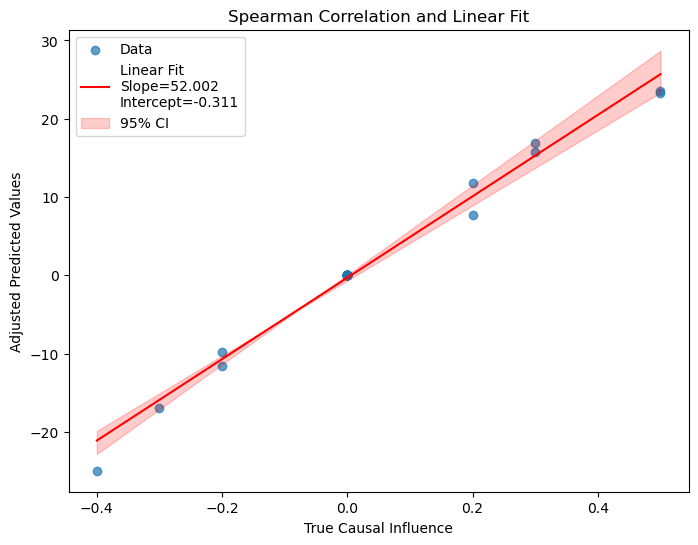

In [6]:
# Simulate synthetic spike train data for trials
causal_matrix = np.array([
    [0.0,  0.3, -0.2,  0.0,  0.0,  0.0],  # Neuron 0 excites Neuron 1, inhibits Neuron 2
    [0.0,  0.0,  0.5,  0.0,  0.0, -0.3],  # Neuron 1 excites Neuron 2, inhibits Neuron 5
    [0.2,  0.0,  0.0,  0.0, -0.4,  0.0],  # Neuron 2 excites Neuron 0, inhibits Neuron 4
    [0.0, -0.2,  0.0,  0.0,  0.3,  0.0],  # Neuron 3 inhibits Neuron 1, excites Neuron 4
    [0.0,  0.0,  0.0,  0.0,  0.0,  0.5],  # Neuron 4 excites Neuron 5
    [0.0,  0.0,  0.2,  0.0,  0.0,  0.0],  # Neuron 5 excites Neuron 2
])
simulated_data_trials = generate_synthetic_spike_data_trials(
    neurons=6, trials=100, time_steps=100, causal_matrix=causal_matrix, base_rate=0.3, noise_level=0.3
)

# Analyze Granger causality with cross-validation
optimal_lags, gc_matrix, signed_gc_matrix = compute_granger_causality(
    simulated_data_trials, 
    lags=np.arange(1, 20)
)

# Filter indirect connections
filtered_gc_matrix, filtered_signed_gc_matrix = filter_indirect_connections(
    optimal_lags,
    gc_matrix,
    signed_gc_matrix
)

# Perform permutation test
significant_gc_matrix, null_distribution, permuted_gc_matrices = permutation_test(
    optimal_lags,
    filtered_gc_matrix,
    filtered_signed_gc_matrix,
    simulated_data_trials,
    n_permutations=1000,
    n_jobs=4
)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
maxabs = np.max(np.abs(causal_matrix))
plt.imshow(causal_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Causal influence')
plt.title("True Causal Matrix")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 2)
maxabs = np.max(np.abs(signed_gc_matrix))
plt.imshow(signed_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Unthresholded)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 3)
maxabs = np.max(np.abs(significant_gc_matrix))
plt.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Significant Only)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.tight_layout()
plt.show()

# Print Granger causality matrix
print("Granger Causality Matrix (Unthresholded):")
print(gc_matrix)
print("signed Granger Causality Matrix (Unthresholded):")
print(signed_gc_matrix)
print("\nSignificant Granger Causality Matrix:")
print(significant_gc_matrix)


# Flatten the matrices
true_values = causal_matrix.flatten()
predicted_values = significant_gc_matrix.flatten()

adjusted_predicted_values=np.sign(predicted_values)*np.sqrt(np.abs(predicted_values))

# Compute Spearman correlation
spearman_corr, spearman_pval = spearmanr(true_values, adjusted_predicted_values)

# Bootstrapped confidence intervals for linear regression
bootstrapped_slopes = []
bootstrapped_intercepts = []
n_bootstraps = 1000
for _ in range(n_bootstraps):
    resampled_true, resampled_predicted = resample(true_values, adjusted_predicted_values)
    if not np.all(resampled_true==0):
        slope, intercept = np.polyfit(resampled_true, resampled_predicted, 1)
        bootstrapped_slopes.append(slope)
        bootstrapped_intercepts.append(intercept)

# Compute 95% CI
slope_ci = np.percentile(bootstrapped_slopes, [2.5, 97.5])
intercept_ci = np.percentile(bootstrapped_intercepts, [2.5, 97.5])

# Fit the linear regression line for plotting
slope, intercept = np.polyfit(true_values, adjusted_predicted_values, 1)
line_x = np.linspace(true_values.min(), true_values.max(), 100)
line_y = slope * line_x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_values, adjusted_predicted_values, alpha=0.7, label='Data')
plt.plot(line_x, line_y, color='red', label=f'Linear Fit\nSlope={slope:.3f}\nIntercept={intercept:.3f}')
plt.fill_between(line_x, slope_ci[0] * line_x + intercept_ci[0], slope_ci[1] * line_x + intercept_ci[1], 
                 color='red', alpha=0.2, label='95% CI')
plt.xlabel('True Causal Influence')
plt.ylabel('Adjusted Predicted Values')
plt.title('Spearman Correlation and Linear Fit')
plt.legend()

# Display Spearman results
print(f'Spearman rho={spearman_corr}, p={spearman_pval}')


Data contains 7 neurons, 100 trials, and 100 time steps.


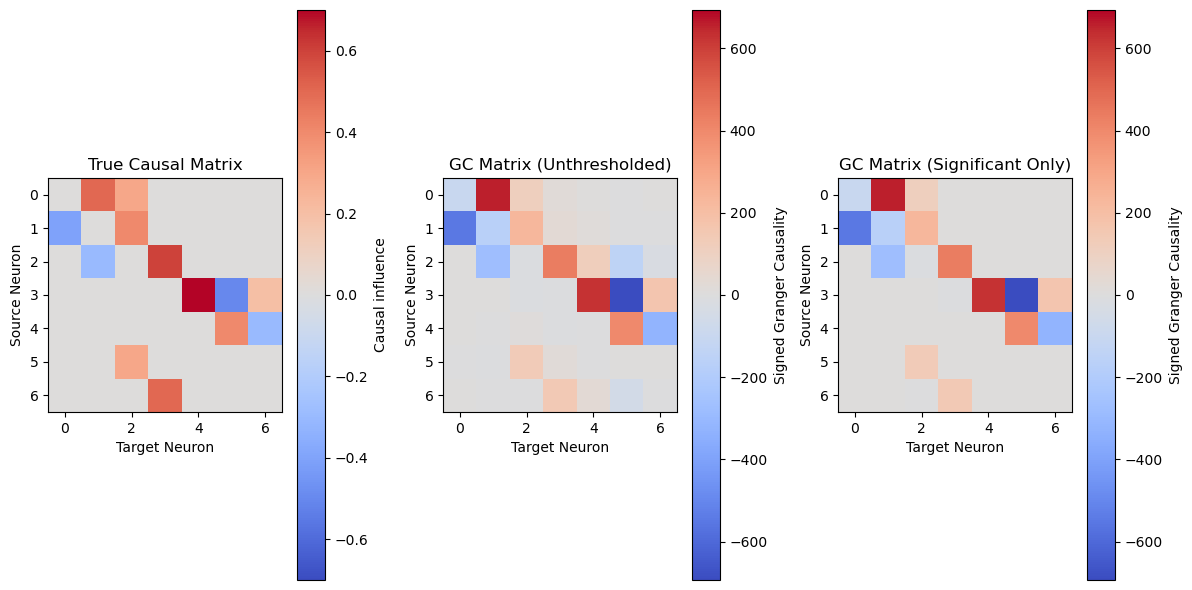

Granger Causality Matrix (Unthresholded):
[[9.78519806e+01 6.57123967e+02 1.09265355e+02 1.79534317e+01
  4.57092740e-02 5.32098316e-01 1.20913806e+00]
 [5.52345952e+02 1.66002705e+02 2.28344350e+02 3.10017741e+01
  1.10167866e+01 5.17312912e-03 6.42622481e-02]
 [4.04605116e-01 2.71444683e+02 1.55746844e+01 4.35516389e+02
  1.17818037e+02 1.41676446e+02 2.37242245e+01]
 [8.72725880e-01 7.82502095e-01 1.38457997e+01 8.45792958e+00
  6.26638145e+02 6.93563020e+02 1.65215516e+02]
 [1.42004458e+00 1.14512073e-01 7.21112980e+00 5.89797514e+00
  2.34940566e-02 3.99293258e+02 3.22769060e+02]
 [2.75705046e-02 8.40589588e+00 1.33293142e+02 1.68157925e+01
  7.70119400e-02 1.96116715e-01 1.73431695e+00]
 [1.50404934e+00 1.34991189e-01 1.90329382e+00 1.45346863e+02
  3.08888603e+01 5.12839350e+01 1.32475031e+00]]
signed Granger Causality Matrix (Unthresholded):
[[-9.78519806e+01  6.57123967e+02  1.09265355e+02  1.79534317e+01
   4.57092740e-02 -5.32098316e-01  1.20913806e+00]
 [-5.52345952e+02 -1.

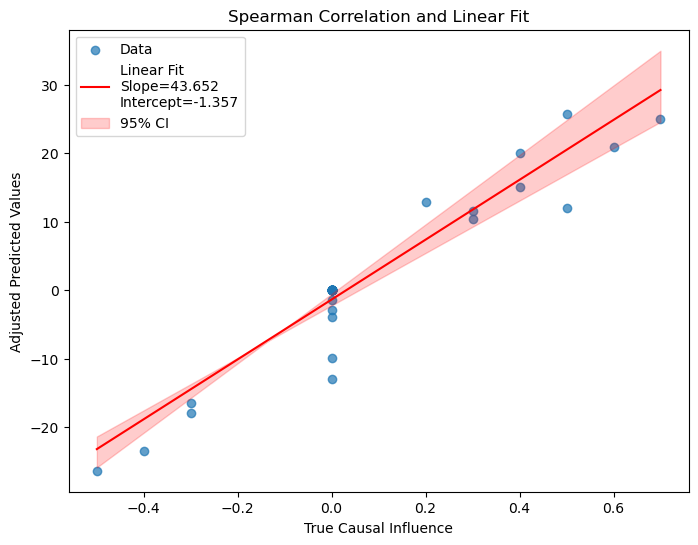

In [7]:
# Simulate synthetic spike train data for trials
causal_matrix = np.array([
    [0.0,  0.5,  0.3,  0.0,  0.0,  0.0,  0.0],  # Neuron 0 excites Neurons 1, 2
    [-0.4, 0.0,  0.4,  0.0,  0.0,  0.0,  0.0],  # Neuron 1 inhibits 0, excites 2
    [0.0, -0.3, 0.0,  0.6,  0.0,  0.0,  0.0],  # Neuron 2 inhibits 1, excites 3
    [0.0,  0.0,  0.0,  0.0,  0.7, -0.5,  0.2],  # Neuron 3 excites 4, inhibits 5, excites 6
    [0.0,  0.0,  0.0,  0.0,  0.0,  0.4, -0.3],  # Neuron 4 excites 5, inhibits 6
    [0.0,  0.0,  0.3,  0.0,  0.0,  0.0,  0.0],  # Neuron 5 excites 2
    [0.0,  0.0,  0.0,  0.5,  0.0,  0.0,  0.0],  # Neuron 6 excites 3
])
simulated_data_trials = generate_synthetic_spike_data_trials(
    neurons=7, trials=100, time_steps=100, causal_matrix=causal_matrix, base_rate=0.3, noise_level=0.3
)

# Analyze Granger causality with cross-validation
optimal_lags, gc_matrix, signed_gc_matrix = compute_granger_causality(
    simulated_data_trials, 
    lags=np.arange(1, 20)
)

# Filter indirect connections
filtered_gc_matrix, filtered_signed_gc_matrix = filter_indirect_connections(
    optimal_lags,
    gc_matrix,
    signed_gc_matrix
)

# Perform permutation test
significant_gc_matrix, null_distribution, permuted_gc_matrices = permutation_test(
    optimal_lags,
    filtered_gc_matrix,
    filtered_signed_gc_matrix,
    simulated_data_trials,
    n_permutations=1000,
    n_jobs=4
)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
maxabs = np.max(np.abs(causal_matrix))
plt.imshow(causal_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Causal influence')
plt.title("True Causal Matrix")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 2)
maxabs = np.max(np.abs(signed_gc_matrix))
plt.imshow(signed_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Unthresholded)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 3)
maxabs = np.max(np.abs(significant_gc_matrix))
plt.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Significant Only)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.tight_layout()
plt.show()

# Print Granger causality matrix
print("Granger Causality Matrix (Unthresholded):")
print(gc_matrix)
print("signed Granger Causality Matrix (Unthresholded):")
print(signed_gc_matrix)
print("\nSignificant Granger Causality Matrix:")
print(significant_gc_matrix)


# Flatten the matrices
true_values = causal_matrix.flatten()
predicted_values = significant_gc_matrix.flatten()

adjusted_predicted_values=np.sign(predicted_values)*np.sqrt(np.abs(predicted_values))

# Compute Spearman correlation
spearman_corr, spearman_pval = spearmanr(true_values, adjusted_predicted_values)

# Bootstrapped confidence intervals for linear regression
bootstrapped_slopes = []
bootstrapped_intercepts = []
n_bootstraps = 1000
for _ in range(n_bootstraps):
    resampled_true, resampled_predicted = resample(true_values, adjusted_predicted_values)
    if not np.all(resampled_true==0):
        slope, intercept = np.polyfit(resampled_true, resampled_predicted, 1)
        bootstrapped_slopes.append(slope)
        bootstrapped_intercepts.append(intercept)

# Compute 95% CI
slope_ci = np.percentile(bootstrapped_slopes, [2.5, 97.5])
intercept_ci = np.percentile(bootstrapped_intercepts, [2.5, 97.5])

# Fit the linear regression line for plotting
slope, intercept = np.polyfit(true_values, adjusted_predicted_values, 1)
line_x = np.linspace(true_values.min(), true_values.max(), 100)
line_y = slope * line_x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_values, adjusted_predicted_values, alpha=0.7, label='Data')
plt.plot(line_x, line_y, color='red', label=f'Linear Fit\nSlope={slope:.3f}\nIntercept={intercept:.3f}')
plt.fill_between(line_x, slope_ci[0] * line_x + intercept_ci[0], slope_ci[1] * line_x + intercept_ci[1], 
                 color='red', alpha=0.2, label='95% CI')
plt.xlabel('True Causal Influence')
plt.ylabel('Adjusted Predicted Values')
plt.title('Spearman Correlation and Linear Fit')
plt.legend()

# Display Spearman results
print(f'Spearman rho={spearman_corr}, p={spearman_pval}')
